In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
from typing import List
import networkx as nx
from qtensor.tools import maxcut
from cartesian_explorer import parallels, dict_product
from tqdm.auto import tqdm
import xarray
import sarge
from pathlib import Path

## Set up MQLib

Install from here: https://github.com/MQLib/MQLib

In [5]:
MQLib_dir = Path().home() / 'git-built/MQLib'
MQLib_bin = MQLib_dir / 'bin/MQLib'
MQLib_heuristics = 'BURER2002' # the best so far
print('MQLib is expected to be in', MQLib_dir)
print('--Expected to see "ERROR: Invalid usage."--\n--')
print(sarge.get_stdout(str(MQLib_bin)+' --help'))

MQLib is expected to be in /home/smooth/git-built/MQLib
--Expected to see "ERROR: Invalid usage."--
--
ERROR: Invalid usage.
MQLib: Library of Max-Cut and QUBO heuristics

USAGE: 
# Run Max-Cut or QUBO heuristic
./bin/MQlib -h heur_code | -hh -fM maxcut_file [-nv] [-ps] [-q | -r runtime_limit] [-s SEED]
./bin/MQlib -h heur_code | -hh -fQ qubo_file [-nv] [-ps] [-q | -r runtime_limit] [-s SEED]

# Compute metrics for an input file
./bin/MQlib -fM maxcut_file [-mh] [-m]
./bin/MQlib -fQ qubo_file [-mh] [-m]

# List the available heuristics.
./bin/MQlib -l

OPTIONS:

-fM, --fileMaxCut ARG   Filename for Max-Cut problem instance.
-fQ, --fileQUBO ARG     Filename for QUBO problem instance.
-h, --heuristic ARG     Heuristic code.
-hh, --hyperheuristic   Use the Max-Cut hyper-heuristic
-l, --listHeuristics    List all heuristic codes and brief descriptions
-m, --metrics           Output problem instance statistics.
-mh, --metricsHeader    Output header for problem instance statistics
-nv, --no-

In [6]:
!mkdir ../mqlib_graphs

In [7]:
def run_mqlib_maxcut(file, heuristics, time=None, seed=10):
    cmd = str(MQLib_bin) + f' -h {heuristics}'
    cmd += f' -fM {file}'
    if time:
        cmd += f' -r {time}'
    cmd += f' -s {seed}'
    return sarge.get_stdout(cmd)

In [8]:
def convert_graph_to_maxcut(G: nx.Graph, file) -> List[str]:
    """ Assert maxcut with unity coefficients
    Returns:
        lines for the maxcut problem file
    """
    V = G.number_of_nodes()
    E = G.number_of_edges()
    first_line = f'{V} {E}'
    lines = [first_line]
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    for i, j in G.edges:
        lines.append(f"{i} {j} 1")
    with open(test_file, 'w+') as f:
        f.writelines('\n'.join(lines))
    return lines


In [9]:
test_file = '../mqlib_graphs/test.txt'
G = nx.random_regular_graph(3, 14, seed=10) 
lines = convert_graph_to_maxcut(G, test_file)

run_mqlib_maxcut(test_file, MQLib_heuristics, time=.3)

'0.3,BURER2002,"../mqlib_graphs/test.txt",18,0.300005,[0:8e-06;18:0.000118]\n'

In [10]:
cost, sol = maxcut.maxcut_optimal(G)
print('Optimal maxcut', cost)

Optimal maxcut 18.0


In [11]:
def solve_mqlib_maxcut(G, time=5, seed=10):
    graph_name = '/tmp/mqlib_tmp_gr.txt'
    convert_graph_to_maxcut(G, graph_name)
    out = run_mqlib_maxcut(test_file, MQLib_heuristics, time=time, seed=seed)
    keys = ['runtime_limit', 'heuristic', 'filename', 'cost', 'runtime', 'history']
    values = out.split(',')
    res = dict(zip(keys, values))
    history = res['history'].strip()[1:-1]
    history = history.split(';')
    history = [x.split(':') for x in history]
    costs, times = zip(*history)
    history = dict(costs=[float(x) for x in costs],
                   times=[float(x) for x in times]
                  )
    res['history'] = history
    res['cost'] = float(res['cost'])
    res['runtime'] = float(res['runtime'])
    res['runtime_limit'] = float(res['runtime_limit'])
    return res

In [12]:
solve_mqlib_maxcut(G, time=.5)

{'runtime_limit': 0.5,
 'heuristic': 'BURER2002',
 'filename': '"../mqlib_graphs/test.txt"',
 'cost': 18.0,
 'runtime': 0.500017,
 'history': {'costs': [0.0, 18.0], 'times': [2e-06, 9.6e-05]}}

## Do some benchmarks

### Multiple graphs

In [13]:
Ns = np.array([    30,     64,    100,    150,    320,    490,    660,    830,   1000,
         1400,   2600,   3800,   5000,   5200,   7600,  10000,  12400,  15000,
        20000,  25000,  30000,  35000,  40000,  50000,  75000, 100000])
Ns = np.array([20, 26, 40, 100, 160, 640, 1280, 2560, 10_000, 20_000, 100_000])
Ns = np.array([40, 160, 1280, 10_000])
time = 1
seeds = range(10)
graphs = [nx.random_regular_graph(3, N, seed=s) for N in Ns for s in seeds]
results = []
for G in tqdm(graphs):
    results.append(solve_mqlib_maxcut(G, time=time))

  0%|          | 0/110 [00:00<?, ?it/s]

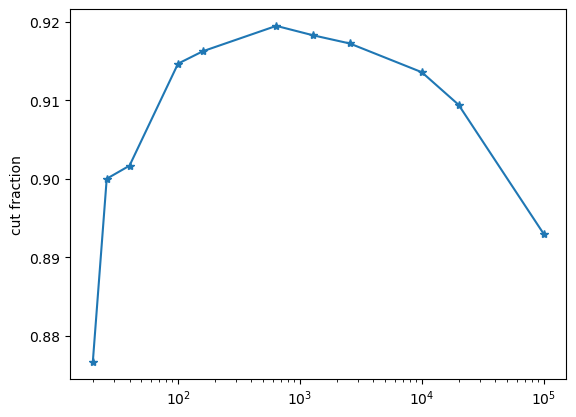

In [14]:
costs = np.array([x['cost'] for x in results])
costs = np.array(costs).reshape(-1, len(seeds))
perf_thr = 40

plt.plot(Ns, costs.mean(-1)/Ns/3*2, '*-')
plt.ylabel('cut fraction')
plt.xscale('log')

In [34]:
xx = xarray.DataArray(costs, dims=('N', 'seed'), coords=dict(N=Ns, seed=seeds))
xx.to_netcdf('../mqlib_cost_v_N.nc')

### History for single graph

This section aims to 
1. gauge the variability of MQLib performance
2. Analyze the scaling of performance when time is much langer than usual (1 second). This is done by calculating the advantage frequency for QAOA p=11
3. Analyze the variability of MQLib with different grahphs. This randomness should commute with the random run of MQLib

#### Same graph seed: look at variability of MQLib

In [29]:
select_N = 10000
time = 60
seeds = range(10)
results = []
for seed in seeds:
    G = nx.random_regular_graph(3, select_N, seed=10)
    res = solve_mqlib_maxcut(G, time=time, seed=seed)
    results.append(res)

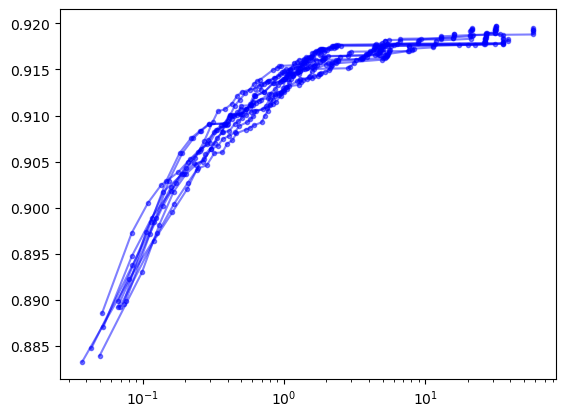

In [30]:
start = 1
for res in results:
    h = res['history']
    costs = np.array(h['costs'])[start:]
    plt.plot(h['times'][start:], costs/select_N/3*2, '.-', color='blue', alpha=.5)
    plt.xscale('log')

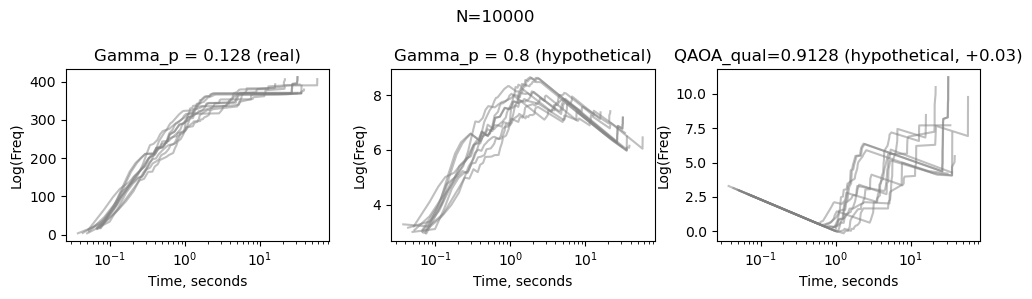

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for res in results:
    h = res['history']
    costs = np.array(h['costs'])[start:]/select_N/3*2
    times = np.array(h['times'])[start:]
    QAOA_qual = 0.8828425
    delta = costs-QAOA_qual
    delta = delta*(delta>0)
    plt.sca(axs[0])
    gamma_p = 0.128
    freqs = -np.log(times)+(select_N/2.0*(delta/gamma_p)**2)
    #freqs = +(select_N/2.0*(delta/gamma_p)**2)
    plt.plot(times, freqs, color='grey', alpha=0.5)
    plt.title(f"Gamma_p = {gamma_p} (real)")
    
    plt.sca(axs[1])
    gamma_p = .8
    plt.title(f"Gamma_p = {gamma_p} (hypothetical)")
    freqs = -np.log(times)+(select_N/2.0*(delta/gamma_p)**2)
    #freqs = +(select_N/2.0*(delta/gamma_p)**2)
    plt.plot(times, freqs, color='grey', alpha=0.5)
    
    plt.sca(axs[2])
    QAOA_qual = 0.9128
    delta = costs-QAOA_qual
    delta = delta*(delta>0)
    gamma_p = .128
    plt.title(f"QAOA_qual={QAOA_qual} (hypothetical, +0.03)")
    freqs = -np.log(times)+(select_N/2.0*(delta/gamma_p)**2)
    #freqs = +(select_N/2.0*(delta/gamma_p)**2)
    plt.plot(times, freqs, color='grey', alpha=0.5)
    
    
for ax in axs:
    plt.sca(ax)
    plt.xscale('log')
    plt.xlabel('Time, seconds')
    plt.ylabel('Log(Freq)')

plt.suptitle(f"N={select_N}")
plt.tight_layout()

#### Different graph seeds

In [120]:
select_N = 256
time = 2
seeds = range(30)
results = []
for seed in seeds:
    G = nx.random_regular_graph(3, select_N, seed=seed)
    res = solve_mqlib_maxcut(G, time=time)
    results.append(res)

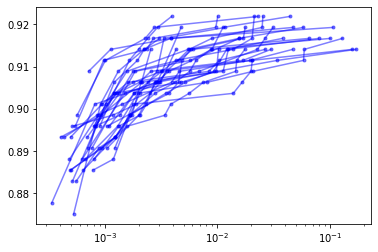

In [124]:
start = 1
for res in results:
    h = res['history']
    costs = np.array(h['costs'])[start:]
    plt.plot(h['times'][start:], costs/select_N/3*2, '.-', color='blue', alpha=.5)
    plt.xscale('log')

In [123]:
with open('../mqlib_data.pkl', 'wb+') as f:
    pickle.dump(results, f)

---